# What Psychiatric Features to Look for in Patients with Different Numbers of Past Suicde Attempts

Although most clinics and hospitals have an established safety protocol for patients who demonstrate <i> current </i> suicide risk, 
we often overlook the importance of <i> past </i> suicide attempts. 
We may put the number of past suicide attempts in the patient's intake record and label the patient at higher risk than those without past suicidal history. 
However, we have no guidelines on further steps for risk prevention when there is no suspected current suicidal risk. 
Without further psychiatric assessment and/or treatment referral, we will likely miss the critical chance to treat the underlying causes of the patient's self-destructive tendency before their next attempt. 
Ideally, all patients at higher risk should receive a comprehensive psychiatric evaluation. 
However, most clinics and hospitals do not have such capacity. Care providers are often required to make an immediate decision within a limited time. 
Therefore, it is important to identify critical psychiatric features that differentiate patients who report different numbers of past suicide attempts such that we can prioritize further assessment of relevant psychiatric history. 


The current study aimed to identify differentiating psychiatric features in patients with different numbers of past suicide attempts using a decision tree regressor.

In [683]:
#Load Packages and Set Display Options
import numpy as np
import pandas as pd
import warnings
from pandas.core.common import SettingWithCopyWarning
from dfply import *
from sklearn import tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import resample
import graphviz 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.options.display.max_seq_items=300

In [504]:
#Load Data
df = pd.read_spss('../Data/PsychiatricDiagnosisandSuicideAttempts/database_suicide_diagnosis.sav')

#Reverse dx coding, so present dx = 1 and absent dx = 0
df[list(df.filter(regex='current').columns)] = abs(df.filter(regex='current')-1)

In [505]:
#Serious Suicide Attempt
df['sSui'] = df['a51'].astype('float') + df['a53'].astype('float') #Serious SA in past year + before past year

#Non-serious Suicide Attempt
df.a54 = df.a54.replace('TOO_MANY', 'NaN') 
df['nsSui'] = df['a52'].astype('float') + df['a54'].astype('float') #Non-serious SA in past year + before past year

In [508]:
print('Missing data points in serious suicide attempt:', sum(df.sSui.isna()))
print('Missing data points in non-serious suicide attempt:', sum(df.nsSui.isna()))

Missing data points in serious suicide attempt: 5
Missing data points in non-serious suicide attempt: 7


## Visualize the Frequency of Past Suicide Attemps

In [509]:
#Sample size of each number of past serious SA
df.sSui.value_counts()

0.0      3303
1.0       246
2.0        62
3.0        21
4.0         7
5.0         7
8.0         5
10.0        5
6.0         4
7.0         3
12.0        2
9.0         2
17.0        1
101.0       1
Name: sSui, dtype: int64

The first column indicates the number of past suicide attempts, and the second column indicates the number of people who reported having this number of past suicide attempts. 

It is improbable a person has 101 past suicide attempts, so we coded it as "NaN." It is likely because the coder gave "98" to people who answered, "too many to count."

In [517]:
#Sample size of each number of past non-serious SA
df.sSui = df.sSui.replace(101.0, float('NaN'))
df.sSui = df.sSui.astype('float')
df.nsSui.value_counts()

0.0     3248
1.0      276
2.0       73
3.0       31
5.0       11
4.0       10
8.0        6
6.0        3
9.0        2
20.0       2
15.0       1
45.0       1
10.0       1
48.0       1
16.0       1
Name: nsSui, dtype: int64

## Compare Serious vs. Non-Serious Suicide Attempts

Here we need to decide whether to combine the two types of suicide attempts or not. If we see a high correlation between the two types of attempts, we can very well consider them the same type of behavior and sum the suicide attempt numbers up. If not, we should view them as distinct behaviors and conduct separate analyses.

In [516]:
"Correlation between serious and non-serious suicidal attempts: %.2f" % df.nsSui.corr(df.sSui)

'Correlation between serious and non-serious suicidal attempts: 0.07'

Given the low correlation, it is best to view serious and non-serious suicide attempts as distinct behaviors. For clinical importance, the following analysis only focuses on serious-suicide attempts. 

## Decision Tree Estimation

In [679]:
#Prepare Data for Decision Tree

#Multiple Imputation
df4Tree = df.filter(regex='current|^sSui$') 
df4TreeComp = df4Tree.dropna()
df4TreeComp.shape

(3668, 40)

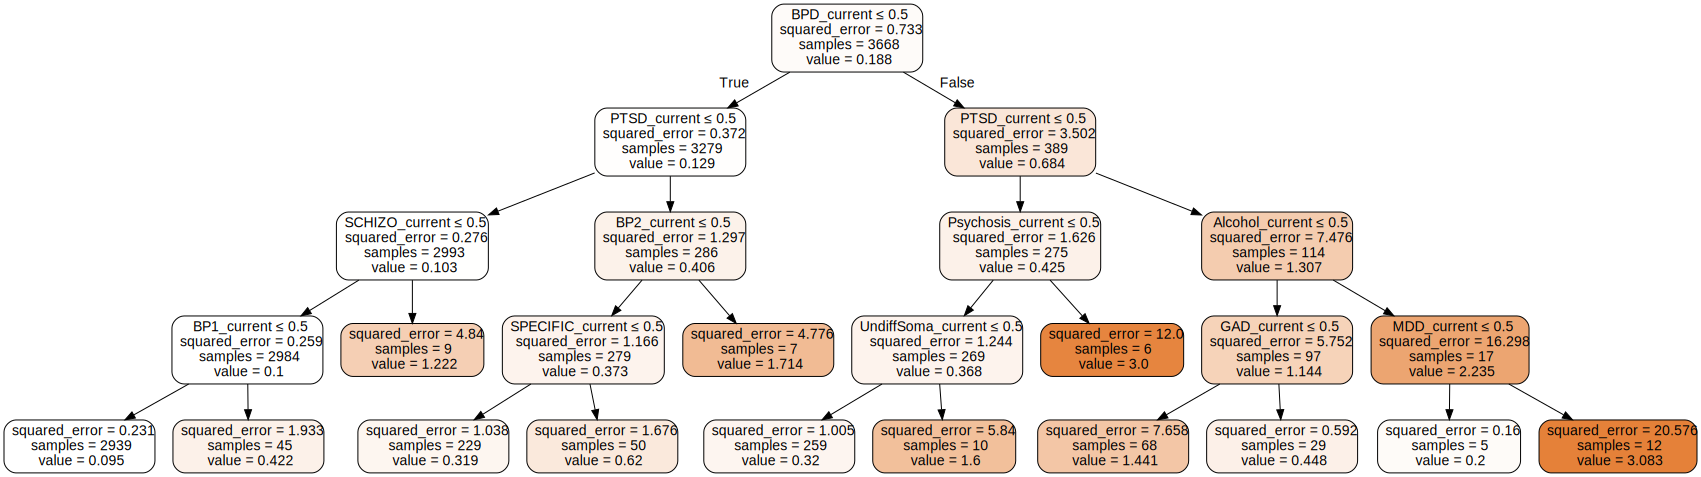

In [680]:
X, y = df4TreeComp.filter(regex='current'), df4TreeComp.sSui

clf = tree.DecisionTreeRegressor(min_weight_fraction_leaf = 0.001, max_depth=4) #Regressor for continuous y var.
treeReg = clf.fit(X, y)
dot_data = tree.export_graphviz(treeReg,  
                      feature_names=df4Tree.filter(regex = 'current').columns,
                      filled=True, rounded=True,
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('../Results/TreeReg')
graph 

In [681]:
#Cut serious suicide attempts into three groups: 0, 1, 2, 3+
df4TreeComp['sSuiCut'] = pd.cut(df4TreeComp.sSui, [-1,0,1,2,99]) 
df4TreeComp['sSuiCut'].value_counts()
df4TreeComp['sSuiCut'] = df4TreeComp['sSuiCut'].cat.rename_categories(['0','1','2','3+'])
df4TreeComp.sSuiCut.value_counts()


0     3303
1      246
2       62
3+      57
Name: sSuiCut, dtype: int64

In [684]:
(df4TreeComp >> 
 group_by('sSuiCut') >> 
 summarize(mean = mean(X.BPD_current)))

,sSuiCut,mean
0,0,0.084771
1,1,0.276423
2,2,0.225806
3,3+,0.473684


In [685]:
(df4TreeComp >> 
 group_by('sSuiCut') >> 
 summarize(mean = mean(X.PTSD_current)))

,sSuiCut,mean
0,0,0.089313
1,1,0.231707
2,2,0.306452
3,3+,0.508772


In [686]:
BPD_PTSD = []
for i in range(df4TreeComp.shape[0]):
    if (df4TreeComp.BPD_current.iloc[i] == 1 and  df4TreeComp.PTSD_current.iloc[i] == 1):
        BPD_PTSD.append(1)
    else:
        BPD_PTSD.append(0)
        
df4TreeComp['BPD_PTSD'] = BPD_PTSD

In [687]:
(df4TreeComp >> 
 group_by('sSuiCut') >> 
 summarize(mean = mean(X.BPD_PTSD)))

,sSuiCut,mean
0,0,0.019679
1,1,0.105691
2,2,0.129032
3,3+,0.263158


In [664]:
0.473684 + 0.508772 - 0.263158

0.719298

In [701]:
Thought = []
for i in range(df4TreeComp.shape[0]):
    if ((df4TreeComp.BP1_current.iloc[i] == 1 or  df4TreeComp.BP2_current.iloc[i] == 1 or 
        df4TreeComp.Psychosis_current.iloc[i] == 1 or df4TreeComp.SCHIZO_current.iloc[i] == 1) 
        and (df4TreeComp.BPD_current.iloc[i] == 0 or df4TreeComp.PTSD_current.iloc[i] == 0)):
        Thought.append(1)
    else:
        Thought.append(0)
        
df4TreeComp['Thought'] = Thought

In [702]:
(df4TreeComp >> 
 group_by('sSuiCut') >> 
 summarize(mean = mean(X.Thought)))

,sSuiCut,mean
0,0,0.048441
1,1,0.081301
2,2,0.129032
3,3+,0.192982
